# Pytorch starter - FasterRCNN Train

You can find the [inference notebook here](https://kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-inference)

- FasterRCNN from torchvision
- Uses Resnet50 backbone
- Albumentation enabled (flip + shift-scale-rotate)
- Original Dicom Images (resized by faster-rcnn)
- No validation yet

I trained the latest version (LB: 0.91) on my local machine; the settings were the same as in this notebook (v12).

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())


1.12.1.post201
0.13.0a0+8069656
True


# convert_to_coco(data_coco 있으면 pass)

In [4]:
# split_data.py

from glob import glob
import shutil
import os
import random

"""f = open("C:/A/lesionData/data_path.txt", 'r')
datapath = f.readline()[:-1]
f.close()"""

load_dir = '/home/ubuntu/lesionData/data'
save_dir = '/home/ubuntu/lesionData/data_split'

files = glob('%s/train/*.json' % load_dir)
random.shuffle(files)

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

shutil.copyfile('%s/class_id_info.csv' % load_dir, "%s/class_id_info.csv" % save_dir)
shutil.copyfile('%s/sample_submission.csv' % load_dir, "%s/sample_submission.csv" % save_dir)
shutil.copytree("%s/test" % load_dir, "%s/test" % save_dir)

num_all = len(files)
num_valid = round(0.1 * num_all)

ind = 0
for file in files:
    if ind < num_all - num_valid:
        shutil.copyfile(file, "%s/train/%s" % (save_dir, os.path.basename(file)))
    else:
        shutil.copyfile(file, "%s/valid/%s" % (save_dir, os.path.basename(file)))
    ind += 1
    

In [2]:
# convert_to_coco.py
# basic setup
import numpy as np
import json
import base64
import os
import random
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

from collections import defaultdict

base_dir = '/home/ubuntu/lesionData/data_split'
save_dir = "/home/ubuntu/lesionData/data_coco"

def convert_to_coco(
    json_paths, # 변경
    save_path,
    save_folder,
):
    """
        only for train dataset
    """
    res = defaultdict(list)
    # 제거
    # json_paths = glob(os.path.join(root_path, 'train', '*.json'))
    categories = {
        '01_ulcer': 1,
        '02_mass': 2,
        '04_lymph': 3,
        '05_bleeding': 4
    }
    
    n_id = 0
    for json_path in tqdm(json_paths):
        with open(json_path, 'r') as f:
            tmp = json.load(f)

        # [추가] train image 저장
        image = BytesIO(base64.b64decode(tmp['imageData']))
        image = Image.open(image).convert('RGB')
        
        image.save(os.path.join(save_dir, save_folder, tmp['file_name'].split(".")[0]+".jpg"))
        
        image_id = int(tmp['file_name'].split('_')[-1][:6])
        res['images'].append({
            'id': image_id,
            'width': tmp['imageWidth'],
            'height': tmp['imageHeight'],
            'file_name': tmp['file_name'].split(".")[0]+".jpg", # 변경
        })
        
        for shape in tmp['shapes']:
            box = np.array(shape['points']) # 추가
            x1, y1, x2, y2 = \
                    min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
            
            w, h = x2 - x1, y2 - y1
            
            res['annotations'].append({
                'id': n_id,
                'image_id': image_id,
                'category_id': categories[shape['label']],
                'area': w * h,
                'bbox': [x1, y1, x2, y2],
                'iscrowd': 0,
            })
            n_id += 1
    
    for name, id in categories.items():
        res['categories'].append({
            'id': id,
            'name': name,
        })
        
    with open(save_path, 'w') as f:
        json.dump(res, f)
        
save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
    
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

    
random.seed(10)

train_file = glob(os.path.join(base_dir, 'train/*.json'))
valid_file = glob(os.path.join(base_dir, 'valid/*.json'))

convert_to_coco(train_file, os.path.join(save_dir, 'train_annotations.json'), 'train')
convert_to_coco(valid_file, os.path.join(save_dir, 'valid_annotations.json'), 'valid')


##################################test################################################
test_files = sorted(glob(os.path.join(base_dir, 'test/*')))


test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))
        
save_path_dir = os.path.join(save_dir, "test")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

for sample in tqdm(test_json_list):
    
    image_id = sample['file_name'].split(".")[0]
    image = BytesIO(base64.b64decode(sample['imageData']))
    image = Image.open(image).convert('RGB')
    
    image.save(os.path.join(save_dir,"test",image_id+".jpg"))




100%|██████████| 20874/20874 [03:24<00:00, 102.15it/s]


# train annotation.json(train_df 있으면 pass)

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = '/home/ubuntu/lesionData/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VAILD = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'


In [3]:
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [5]:
import json

file_path = DIR_INPUT+"/train_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())

dict_keys(['images', 'annotations', 'categories'])


In [6]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))

56360
72205
4


In [7]:
import pandas as pd

train_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    id=dic['image_id']
    train_dic['image_id'].append(id)
    train_dic['class_id'].append(dic['category_id'])
    if train_dic['class_id'] == 1:
        train_dic['class_name'].append('01_ulcer')
    elif train_dic['class_id'] == 2:
        train_dic['class_name'].append('02_mass')
    elif train_dic['class_id'] == 3:
        train_dic['class_name'].append('04_lymph')
    else:
        train_dic['class_name'].append('05_bleeding')            
    train_dic['x_min'].append(round(dic['bbox'][0],4))
    train_dic['y_min'].append(round(dic['bbox'][1],4))
    train_dic['x_max'].append(round(dic['bbox'][2],4))
    train_dic['y_max'].append(round(dic['bbox'][3],4))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == id:
           train_dic['width'].append(dic2['width'])
           train_dic['height'].append(dic2['height'])
           train_dic['file_name'].append(dic2['file_name'])

    
    
train_df=pd.DataFrame(train_dic)    

72205it [08:59, 133.88it/s]


In [8]:
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.7819,143.9671,468.7243,303.2263,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4444,166.6667,213.6667,377.7778,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.0549,87.5055,319.0000,199.0000,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2088,256.1868,145.0000,319.0000,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4458,319.4578,432.5301,433.9157,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.6923,389.3846,369.0000,542.4615,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0345,255.8621,193.4828,320.6897,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3158,97.3684,412.6316,305.7895,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9474,103.1579,397.8947,188.9474,576,576,train_151345.jpg


In [9]:
# train_df 전체 데이터 정보 저장하기
train_df.to_csv(f'{DIR_INPUT}/train.csv')

In [10]:
train_df.fillna(0, inplace=True) # nan 을 0으로 바꾸고
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.7819,143.9671,468.7243,303.2263,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4444,166.6667,213.6667,377.7778,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.0549,87.5055,319.0000,199.0000,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2088,256.1868,145.0000,319.0000,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4458,319.4578,432.5301,433.9157,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.6923,389.3846,369.0000,542.4615,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0345,255.8621,193.4828,320.6897,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3158,97.3684,412.6316,305.7895,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9474,103.1579,397.8947,188.9474,576,576,train_151345.jpg


In [11]:
print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)
len(train_df)

df Shape: (72205, 10)
No Of Classes: 4


72205

In [4]:
# train_df 전체 데이터 정보 불러오기
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv',index_col=0)
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.7819,143.9671,468.7243,303.2263,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4444,166.6667,213.6667,377.7778,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.0549,87.5055,319.0000,199.0000,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2088,256.1868,145.0000,319.0000,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4458,319.4578,432.5301,433.9157,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.6923,389.3846,369.0000,542.4615,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0345,255.8621,193.4828,320.6897,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3158,97.3684,412.6316,305.7895,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9474,103.1579,397.8947,188.9474,576,576,train_151345.jpg


In [5]:
print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)
len(train_df)

df Shape: (72205, 10)
No Of Classes: 4


72205

In [6]:
train_df["class_id"].value_counts()

1    35079
4    17569
3    10809
2     8748
Name: class_id, dtype: int64

In [7]:
# nunique()는 데이터에 고유값들의 수를 출력해주는 함수
train_df["class_id"].nunique()

4

# valid annotation.json(valid_df 있으면 pass)

In [8]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = '/home/ubuntu/lesionData/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [18]:
import json

file_path = DIR_INPUT+"/valid_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())

dict_keys(['images', 'annotations', 'categories'])


In [19]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))


6262
8013
4


In [20]:
import pandas as pd
# [{'id': 148662, 'width': 320, 'height': 320, 'file_name': 'train_148662.jpg'},

valid_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    id=dic['image_id']
    valid_dic['image_id'].append(id)
    valid_dic['class_id'].append(dic['category_id'])
    if valid_dic['class_id'] == 1:
        valid_dic['class_name'].append('01_ulcer')
    elif valid_dic['class_id'] == 2:
        valid_dic['class_name'].append('02_mass')
    elif valid_dic['class_id'] == 3:
        valid_dic['class_name'].append('04_lymph')
    else:
        valid_dic['class_name'].append('05_bleeding')            
    valid_dic['x_min'].append(round(dic['bbox'][0],4))
    valid_dic['y_min'].append(round(dic['bbox'][1],4))
    valid_dic['x_max'].append(round(dic['bbox'][2],4))
    valid_dic['y_max'].append(round(dic['bbox'][3],4))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == id:
           valid_dic['width'].append(dic2['width'])
           valid_dic['height'].append(dic2['height'])
           valid_dic['file_name'].append(dic2['file_name'])

    
    
valid_df=pd.DataFrame(valid_dic)    

8013it [00:05, 1372.43it/s]


In [21]:
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,148662,05_bleeding,2,205.7895,88.1579,268.9474,151.8421,320,320,train_148662.jpg
1,124857,05_bleeding,4,436.1446,277.3976,531.9277,365.3494,576,576,train_124857.jpg
2,153731,05_bleeding,1,307.4507,308.8592,407.4507,389.8451,576,576,train_153731.jpg
3,153731,05_bleeding,1,422.2394,386.3239,500.4085,456.7465,576,576,train_153731.jpg
4,109031,05_bleeding,1,192.1809,57.9787,258.4043,136.4362,320,320,train_109031.jpg
...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,90.5288,90.3846,131.3942,120.9135,320,320,train_142746.jpg
8009,134031,05_bleeding,3,142.0866,162.7706,229.5325,224.6753,576,576,train_134031.jpg
8010,131307,05_bleeding,1,243.2836,32.8358,476.1194,219.4030,576,576,train_131307.jpg
8011,120195,05_bleeding,1,88.2251,82.0384,241.5038,237.7761,576,576,train_120195.jpg


In [22]:
# valid_df 전체 데이터 정보 저장하기
valid_df.to_csv(f'{DIR_INPUT}/valid.csv')

In [23]:
# 14번 라벨 = NO FINGING : 누락된 데이터(NaN)을 채우고, (0,0,1,1) 로 바꿈 -> nan 그대로 들어가면 안되는 이유!!!
valid_df.fillna(0, inplace=True) # nan 을 0으로 바꾸고
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,148662,05_bleeding,2,205.7895,88.1579,268.9474,151.8421,320,320,train_148662.jpg
1,124857,05_bleeding,4,436.1446,277.3976,531.9277,365.3494,576,576,train_124857.jpg
2,153731,05_bleeding,1,307.4507,308.8592,407.4507,389.8451,576,576,train_153731.jpg
3,153731,05_bleeding,1,422.2394,386.3239,500.4085,456.7465,576,576,train_153731.jpg
4,109031,05_bleeding,1,192.1809,57.9787,258.4043,136.4362,320,320,train_109031.jpg
...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,90.5288,90.3846,131.3942,120.9135,320,320,train_142746.jpg
8009,134031,05_bleeding,3,142.0866,162.7706,229.5325,224.6753,576,576,train_134031.jpg
8010,131307,05_bleeding,1,243.2836,32.8358,476.1194,219.4030,576,576,train_131307.jpg
8011,120195,05_bleeding,1,88.2251,82.0384,241.5038,237.7761,576,576,train_120195.jpg


In [24]:
print("df Shape: "+str(valid_df.shape))
print("No Of Classes: "+str(valid_df["class_id"].nunique()))
valid_df.sort_values(by='image_id').head(10)
len(valid_df)

df Shape: (8013, 10)
No Of Classes: 4


8013

In [10]:
# valid_df 전체 데이터 정보 불러오기
valid_df = pd.read_csv(f'{DIR_INPUT}/valid.csv',index_col=0)
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,148662,05_bleeding,2,205.7895,88.1579,268.9474,151.8421,320,320,train_148662.jpg
1,124857,05_bleeding,4,436.1446,277.3976,531.9277,365.3494,576,576,train_124857.jpg
2,153731,05_bleeding,1,307.4507,308.8592,407.4507,389.8451,576,576,train_153731.jpg
3,153731,05_bleeding,1,422.2394,386.3239,500.4085,456.7465,576,576,train_153731.jpg
4,109031,05_bleeding,1,192.1809,57.9787,258.4043,136.4362,320,320,train_109031.jpg
...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,90.5288,90.3846,131.3942,120.9135,320,320,train_142746.jpg
8009,134031,05_bleeding,3,142.0866,162.7706,229.5325,224.6753,576,576,train_134031.jpg
8010,131307,05_bleeding,1,243.2836,32.8358,476.1194,219.4030,576,576,train_131307.jpg
8011,120195,05_bleeding,1,88.2251,82.0384,241.5038,237.7761,576,576,train_120195.jpg


In [11]:
print("df Shape: "+str(valid_df.shape))
print("No Of Classes: "+str(valid_df["class_id"].nunique()))
valid_df.sort_values(by='image_id').head(10)
len(valid_df)

df Shape: (8013, 10)
No Of Classes: 4


8013

In [12]:
valid_df["class_id"].value_counts()

1    3879
4    1929
3    1193
2    1012
Name: class_id, dtype: int64

In [13]:
# nunique()는 데이터에 고유값들의 수를 출력해주는 함수
valid_df["class_id"].nunique()

4

# Data preparation

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = '/home/ubuntu/lesionData/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:
# train_df 전체 데이터 정보 불러오기
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv',index_col=0)
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.7819,143.9671,468.7243,303.2263,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4444,166.6667,213.6667,377.7778,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.0549,87.5055,319.0000,199.0000,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2088,256.1868,145.0000,319.0000,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4458,319.4578,432.5301,433.9157,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.6923,389.3846,369.0000,542.4615,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0345,255.8621,193.4828,320.6897,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3158,97.3684,412.6316,305.7895,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9474,103.1579,397.8947,188.9474,576,576,train_151345.jpg


In [3]:
# valid_df 전체 데이터 정보 불러오기
valid_df = pd.read_csv(f'{DIR_INPUT}/valid.csv',index_col=0)
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,148662,05_bleeding,2,205.7895,88.1579,268.9474,151.8421,320,320,train_148662.jpg
1,124857,05_bleeding,4,436.1446,277.3976,531.9277,365.3494,576,576,train_124857.jpg
2,153731,05_bleeding,1,307.4507,308.8592,407.4507,389.8451,576,576,train_153731.jpg
3,153731,05_bleeding,1,422.2394,386.3239,500.4085,456.7465,576,576,train_153731.jpg
4,109031,05_bleeding,1,192.1809,57.9787,258.4043,136.4362,320,320,train_109031.jpg
...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,90.5288,90.3846,131.3942,120.9135,320,320,train_142746.jpg
8009,134031,05_bleeding,3,142.0866,162.7706,229.5325,224.6753,576,576,train_134031.jpg
8010,131307,05_bleeding,1,243.2836,32.8358,476.1194,219.4030,576,576,train_131307.jpg
8011,120195,05_bleeding,1,88.2251,82.0384,241.5038,237.7761,576,576,train_120195.jpg


In [4]:
'''
'01_ulcer': 1,
'02_mass': 2,
'04_lymph': 3,
'05_bleeding': 4
'''
def label_to_name(id):
    id = int(id)
    id = id-1

    if id == 0:
        return "01_ulcer"
    if id == 1:
        return "02_mass"
    if id == 2:
        return "04_lymph"
    if id == 3:
        return "05_bleeding"
    else:
        return str(id)

In [5]:
# Clean
# bbox 1 
# 박스 넓이 1이하 삭제 -> bbox가 너무 작으면 오류 **** 해야한다고..
# 작으면 못그린다..................

train_df['area'] = (train_df['x_max'] - train_df['x_min']) * (train_df['y_max'] - train_df['y_min'])
valid_df['area'] = (valid_df['x_max'] - valid_df['x_min']) * (valid_df['y_max'] - valid_df['y_min'])
train_df = train_df[train_df['area'] > 1]
valid_df = valid_df[valid_df['area'] > 1]

#train_df = train_df.drop(['area'], axis = 1)
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,123168,05_bleeding,2,270.7819,143.9671,468.7243,303.2263,576,576,train_123168.jpg,31524.148270
1,123168,05_bleeding,1,51.4444,166.6667,213.6667,377.7778,576,576,train_123168.jpg,34246.928198
2,101247,05_bleeding,1,245.0549,87.5055,319.0000,199.0000,320,320,train_101247.jpg,8244.471952
3,101247,05_bleeding,1,41.2088,256.1868,145.0000,319.0000,320,320,train_101247.jpg,6519.457404
4,161826,05_bleeding,4,311.4458,319.4578,432.5301,433.9157,576,576,train_161826.jpg,13859.054701
...,...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.6923,389.3846,369.0000,542.4615,576,576,train_122215.jpg,26376.328562
72201,131941,05_bleeding,3,110.0345,255.8621,193.4828,320.6897,576,576,train_131941.jpg,5409.753013
72202,151345,05_bleeding,1,256.3158,97.3684,412.6316,305.7895,576,576,train_151345.jpg,32579.510983
72203,151345,05_bleeding,1,308.9474,103.1579,397.8947,188.9474,576,576,train_151345.jpg,7630.744393


In [17]:
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,148662,05_bleeding,2,205.7895,88.1579,268.9474,151.8421,320,320,train_148662.jpg,4022.160335
1,124857,05_bleeding,4,436.1446,277.3976,531.9277,365.3494,576,576,train_124857.jpg,8424.296055
2,153731,05_bleeding,1,307.4507,308.8592,407.4507,389.8451,576,576,train_153731.jpg,8098.590000
3,153731,05_bleeding,1,422.2394,386.3239,500.4085,456.7465,576,576,train_153731.jpg,5504.871262
4,109031,05_bleeding,1,192.1809,57.9787,258.4043,136.4362,320,320,train_109031.jpg,5195.722405
...,...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,90.5288,90.3846,131.3942,120.9135,320,320,train_142746.jpg,1247.575710
8009,134031,05_bleeding,3,142.0866,162.7706,229.5325,224.6753,576,576,train_134031.jpg,5413.312206
8010,131307,05_bleeding,1,243.2836,32.8358,476.1194,219.4030,576,576,train_131307.jpg,43439.523266
8011,120195,05_bleeding,1,88.2251,82.0384,241.5038,237.7761,576,576,train_120195.jpg,23871.272197


# LesionDataset
 

In [8]:
image_ids = train_df['image_id'].unique()

In [25]:
class LesionDataset(Dataset):
    # 초기화
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    # 인덱스를 인자로 받아 훈련(혹은, 검증)에서 사용할 샘플 데이터 튜플을 반환하는 메소드
    # 샘플과 레이블(정수인덱스)로 이루어진 아이템 반환
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        
        #image_type=self.image_dir.split('/')[-1]
        #image_id = str(image_id)
        
        img_dir = self.image_dir
        img_fn = records['file_name'][0]

        image = Image.open(img_dir+'/'+img_fn).convert('RGB')
  
        #image = Image.open('/home/ubuntu/lesionData/data_coco'+'/'+image_type+'/'+image_type+'_'+image_id+'.jpg').convert('RGB')

        """
        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        # pixel_array
        image = dicom.pixel_array
        
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image
        
        # Rescale Intercept
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        # Rescale Slope
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        """
        
        # image는 np.array입니다. 물론 height, width, layer로 되어 있는 조금 복잡한 구조
        # 따라서 이 np.array를 변환하면, 이미지 또한 변합니다. 
        # img.transpose(1, 0, 2)는 원래 height, width, layer -> width, height, layer
        
        #image = np.stack([image, image, image])
        image = np.array(image)
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        #image = image.transpose(2,1,0)

        if records.loc[0, "class_id"] == 0:
            records = records.loc[[0], :]
        
        # bounding box
        # values -> dataframe to array
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # label
        labels = torch.tensor(records["class_id"].values, dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        # 이미지를 파이토치 텐서로 변환 torchvision.transforms
        # img 뿐만 아니라 bounding box, label 모두 tensor 형태로 바꿔야 한다.
        if self.transforms :

            # image, bboxes라는 key값 자체가 있기 때문에 반드시 이름을 이와 같게 해야 한다.
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            print('\n=====================================================================\n')
            print(sample['bboxes'])
            sample = self.transforms(**sample)
            image = sample['image']    
            target['boxes'] = torch.tensor(sample['bboxes'])

        if target["boxes"].shape[0] == 0:
            # Albumentation cuts the target (class 14, 1x1px in the corner)
            target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
            target["area"] = torch.tensor([1.0], dtype=torch.float32)
            target["labels"] = torch.tensor([0], dtype=torch.int64)
            
        return image, target, image_ids
    # 데이터셋의 아이템수
    def __len__(self):
        return self.image_ids.shape[0]

# albumentations

In [26]:
# Albumentations
# format = pascal_voc:어느 데이터셋에 대한 bbox 내용을 가져올 것인지
# label_fields : 우리가 만든 labels
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        # shift, scale, rotate를 한번에 적용
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        # 이미지의 maxsize를 max_size로 rescale합니다. aspect ratio는 유지합니다.
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        # albumentations에서는 ToTensor 대신 ToTensorV2를 사용하는데 
        # ToTesorV2는 ToTensor와 마찬가지로 tensor형변환, channel dimension을 첫번째 차원으로 가져오는 역할을 하지만 min_max scaling은 하지 않는다는 것을 명심하자.
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format = 'pascal_voc',label_fields= ['labels']))

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Model

In [27]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# 1차원 깨질지 돌아가는지
#print(model) # 모델의 입구 생각하기

In [28]:
# no finding 포함 5개 클래스
num_classes = 5

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [29]:
# batch sampler 로 묶인 이후에는, collate_fn을 호출해 batch로 묶는다.
def collate_fn(batch):
    return tuple(zip(*batch))
DIR_TRAIN = '/home/ubuntu/lesionData/data_coco/train'
DIR_VALID = '/home/ubuntu/lesionData/data_coco/valid'
train_dataset = LesionDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = LesionDataset(valid_df, DIR_VALID, get_valid_transform())


# Returns a random permutation of integers from 0 to n - 1.
# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

7


In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Sample



[[399.1111 172.4444 456.4444 226.6667]]





[[ 31.2641  50.6494 172.8225 274.8918]
 [ 86.8649 400.     161.1892 494.5946]]

[[135.4184 146.5709 197.1972 202.0998]]
[[318.1681 404.0084 362.7059 467.0336]
 [210.605   69.5546 373.6303 153.5882]]




[[193.7368 155.391  286.9699 318.5489]][[346.549  300.3922 486.2549 395.    ]]



[[362.7931 248.8621 471.4138 346.2759]]



[[336.214   66.1893 543.6214 274.0082]
 [284.3621 231.2099 350.6173 282.2387]]




[[294.9319 351.3089 395.4555 458.6387]
 [ 33.4314 252.9412 101.0784 352.9412]]
[[148.7013 368.4805 393.5065 533.4156]][[340.7633 272.1893 444.3136 406.5089]
 [344.3136  54.4379 447.8639 152.071 ]]




[[168.2308 234.2527 545.1538 544.1429]]




[[442.5373 129.8507 524.6269 219.403 ]][[260.503  162.7219 292.4556 188.1657]]



[[166.7216  31.9897 543.5258 544.3608]]



[[441.0778 178.4431 470.4192 210.7784]]




[[230.  361.5 360.5 469. ]
 [366.5 354.  526.5 518.5]]

[[138.9831  12.5424 210.1695 120.452 ]][[241.8396 264.7059 327.4011 368.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


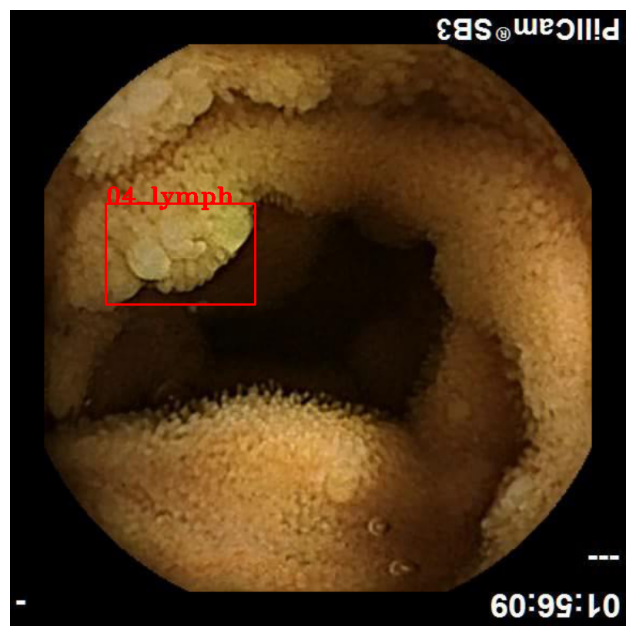

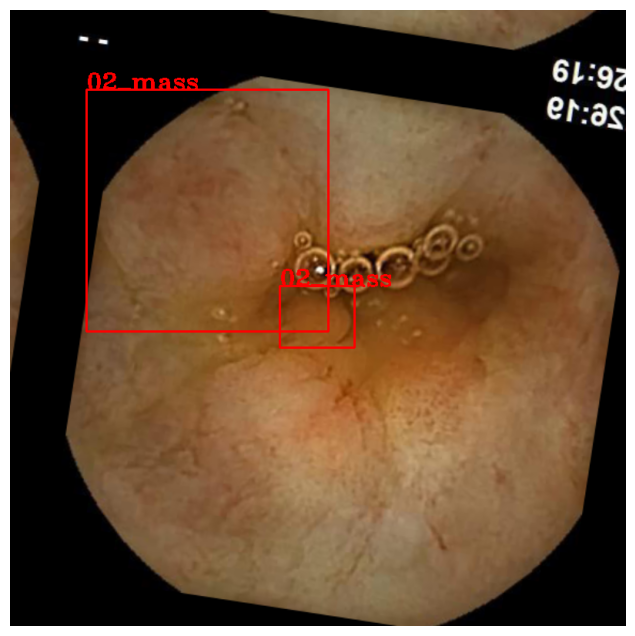

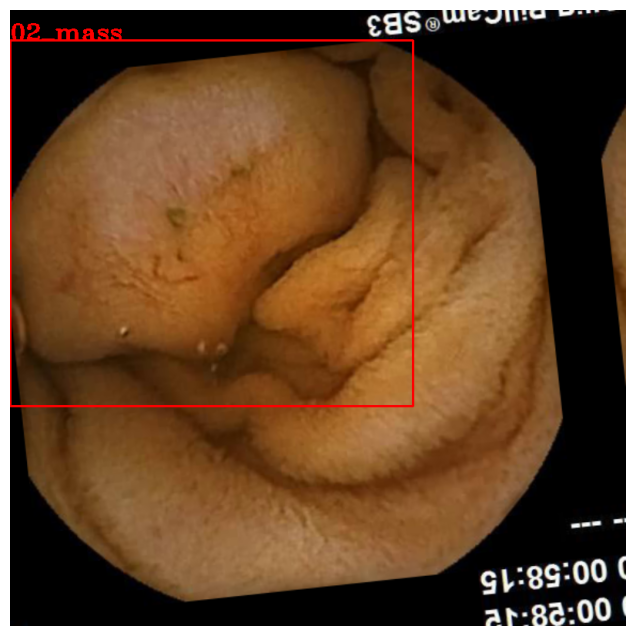

In [31]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for number in random.sample([1,2,3],3):
  boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
  img = images[number].permute(1,2,0).cpu().numpy()
  labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  for i in range(len(boxes)):
      img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
      #print(le.inverse_transform([labels[i]-1])[0])
      #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
      img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

  ax.set_axis_off()
  ax.imshow(img)



# bbox 정규화

In [35]:
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,123168,05_bleeding,2,270.7819,143.9671,468.7243,303.2263,576,576,train_123168.jpg,31524.148270
1,123168,05_bleeding,1,51.4444,166.6667,213.6667,377.7778,576,576,train_123168.jpg,34246.928198
2,101247,05_bleeding,1,245.0549,87.5055,319.0000,199.0000,320,320,train_101247.jpg,8244.471952
3,101247,05_bleeding,1,41.2088,256.1868,145.0000,319.0000,320,320,train_101247.jpg,6519.457404
4,161826,05_bleeding,4,311.4458,319.4578,432.5301,433.9157,576,576,train_161826.jpg,13859.054701
...,...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.6923,389.3846,369.0000,542.4615,576,576,train_122215.jpg,26376.328562
72201,131941,05_bleeding,3,110.0345,255.8621,193.4828,320.6897,576,576,train_131941.jpg,5409.753013
72202,151345,05_bleeding,1,256.3158,97.3684,412.6316,305.7895,576,576,train_151345.jpg,32579.510983
72203,151345,05_bleeding,1,308.9474,103.1579,397.8947,188.9474,576,576,train_151345.jpg,7630.744393


# Train

In [32]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [33]:
# 모델에 사용되는 모든 입력 Tensor들에 대해 input = input.to(device) 을 호출해야 합니다.
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs = 10

In [34]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        # to 메소드를 활용해 gpu로 옮긴다. Data to GPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Label classification, BoundingBox Regression의 Loss 값이 Ditcionary 형태로 나온다.
        loss_dict = model(images, targets)

        # Dict 형태의 loss_dict에서 .values()로 key:values에서 values를 가져온다.
        losses = sum(loss for loss in loss_dict.values())
        
        # losses를 print해보면 tensor()로 감싸져 있다. .item()으로 숫자만 가져오자.
        loss_value = losses.item()

        # loss_hist에 loss_value를 저장한다.
        loss_hist.send(loss_value)

        # optimizer 업데이트
        optimizer.zero_grad() # 1. 기울기 0으로 초기화
        losses.backward()  # 2. 역전파
        optimizer.step() # 3. 업데이트

        # 10번마다 loss값 출력
        if itr % 100 == 0:
            print(f"Iteration #{itr} loss: {loss_hist.value}")

        itr += 1
        
        # !!!REMOVE THIS!!!
        #break
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    print("Saving epoch's state...")
    torch.save(model.state_dict(), f"/home/ubuntu/data_dicom/weights/model_state_epoch_{epoch}.pth")



[[180.1205 111.7349 370.4819 291.253 ]]



[[101.3293 404.1916 185.1617 456.2874]]



[[276.6667  97.3333 368.6667 214.    ]
 [418.      58.6667 488.6667 172.6667]]
[[ 39.5172  91.9655 170.5517 266.1034]]


[[ 32.8129 260.7527 140.7266 410.0647]
 [181.0144 361.8633 302.5971 461.8633]]




[[126.9565 209.     275.6522 332.4783]
 [ 76.5217 213.3478 106.087  315.087 ]]
[[101.8868  77.6792 154.717  123.9057]]


[[183.4646 272.9764 240.9449 313.1339]]



[[ 96.0803 156.438  350.8248 393.6642]]



[[190.2844 196.0459 216.8899 218.9817]][[ 50.3937 139.1181 225.9843 284.    ]]



[[330.6667 329.7778 388.8889 385.7778]]


[[309.3114 366.4671 532.0659 542.515 ]]



[[ 98.2053 284.4305 350.5232 485.755 ]]



[[104.3062 220.1053 180.8612 322.0191]
 [114.8325  60.7751 182.2967 146.4211]][[183.1111  36.8889 540.8889 388.4444]]



[[268.1006 185.2071 359.8166 282.2485]]



[[120.4495 185.7339 192.9266 260.0459]]


[[388.2814 122.5108 484.5    214.7186]
 [219.0173 350.2165 331.5714 455.4113]]


[[14

ValueError: Caught ValueError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_1944/1425054628.py", line 94, in __getitem__
    sample = self.transforms(**sample)
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/albumentations/core/composition.py", line 202, in __call__
    p.preprocess(data)
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/albumentations/core/utils.py", line 83, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/albumentations/core/utils.py", line 91, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 124, in convert_to_albumentations
    return convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=True)
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 390, in convert_bboxes_to_albumentations
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 390, in <listcomp>
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 334, in convert_bbox_to_albumentations
    check_bbox(bbox)
  File "/home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages/albumentations/core/bbox_utils.py", line 417, in check_bbox
    raise ValueError(f"Expected {name} for bbox {bbox} to be in the range [0.0, 1.0], got {value}.")
ValueError: Expected y_min for bbox (0.474835625, -0.0029718749999999997, 0.993585625, 0.38601968750000004, tensor(2)) to be in the range [0.0, 1.0], got -0.0029718749999999997.


# valid

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [35]:
targets

[{'boxes': tensor([[ 597., 1507., 1891., 2141.],
          [ 603., 1341., 1928., 1980.],
          [ 600., 1482., 1956., 2035.]], device='cuda:0', dtype=torch.float64),
  'labels': tensor([4, 4, 4], device='cuda:0'),
  'image_id': tensor([45], device='cuda:0'),
  'area': tensor([820396., 846675., 749868.], device='cuda:0'),
  'iscrowd': tensor([0, 0, 0], device='cuda:0')},
 {'boxes': tensor([[0., 0., 1., 1.]], device='cuda:0', dtype=torch.float64),
  'labels': tensor([0], device='cuda:0'),
  'image_id': tensor([14], device='cuda:0'),
  'area': tensor([1.], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[0., 0., 1., 1.]], device='cuda:0', dtype=torch.float64),
  'labels': tensor([0], device='cuda:0'),
  'image_id': tensor([4], device='cuda:0'),
  'area': tensor([1.], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[0., 0., 1., 1.]], device='cuda:0', dtype=torch.float64),
  'labels': tensor([0], device='cuda:0'),
  'image

In [36]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
#permute() : 모든 차원의 순서를 재배치. 이렇게 바뀐 순서를 다시 원래대로 돌려주기 위해 permute함수가 사용된 것이다.
sample = images[0].permute(1,2,0).cpu().numpy()

In [37]:
# nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수라고 한다.
# .eval() 함수는 evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수인 셈이다.
# model.eval()의 역할은 약간 다르다. 현재(2019년) 시점에서는 모델링 시 training과 inference시에 다르게 동작하는 layer들이 존재한다. 예를 들면, Dropout layer는 학습시에는 동작해야하지만, inference시에는 동작하지 않는 것과 같은 예시를 들 수 있다. BatchNorm같은 경우도 마찬가지다.
# 사실상 model.eval()는 이런 layer들의 동작을 inference(eval) mode로 바꿔준다는 목적으로 사용된다. 따라서, 우리가 보통 원하는 모델의 동작을 위해서는 위의 두 가지를 모두 사용해야하는 것이 맞다.

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [38]:
outputs[5]

{'boxes': tensor([[ 548.6559,  264.8406,  789.5708,  359.6841],
         [ 469.8084,  244.3405,  746.0526,  354.1381],
         [ 537.8614,  268.7436,  740.9654,  324.2870],
         [ 520.0261,  256.5819,  715.4523,  414.8188],
         [ 511.1500,  277.7285,  696.0507,  340.3727],
         [1073.8086,  227.4085, 1347.0481,  333.6952],
         [ 496.2679,  303.2518,  703.9446,  493.9299],
         [ 427.7991,  273.4562,  683.1193,  402.9449],
         [1496.5461, 1875.2787, 1677.3634, 2000.1436],
         [ 484.8865,  328.7908,  824.9387,  534.5633],
         [ 524.0261,  231.4305,  796.6733,  325.8520],
         [ 601.8304,  279.4659,  757.7796,  329.7262],
         [ 549.2692,  303.0759,  784.7354,  405.4013],
         [1143.4648,  196.8596, 1356.3030,  365.8703],
         [ 435.9104,  239.4219,  781.7705,  563.4241],
         [1025.4989,  293.7009, 1388.0033,  634.3474],
         [1081.0535,  286.5145, 1255.3734,  322.0147],
         [ 456.5672,  356.5136,  644.6656,  527.2050],
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


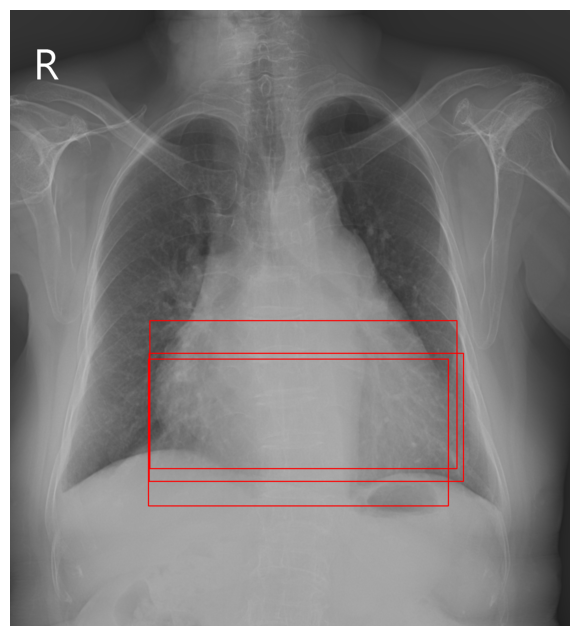

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)